In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import os
from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve
from joblib import Parallel, delayed

from treeple import HonestForestClassifier
from treeple.datasets import make_trunk_classification
from treeple.stats import build_oob_forest
from treeple.tree import (
    MultiViewObliqueDecisionTreeClassifier,
    MultiViewDecisionTreeClassifier,
    ObliqueDecisionTreeClassifier,
)

In [4]:
rng = np.random.default_rng(1234)
n_samples = 1024
# n_dim_1=4091
# default_n_informative = 3
# mu_0=[0, 0, 0]
# mu_1=[0, 0, 0]
n_dim_1 = 4090
default_n_informative = 2
mu_0 = [0, 0.2]
mu_1 = [0, 0]
seed = None
n_dim_2 = 6

cov2 = np.eye(2)

In [5]:
# simulate data with covariance in two views
X, y, means, cov = make_trunk_classification(
    n_samples=n_samples,
    n_dim=n_dim_1 + 1,
    n_informative=default_n_informative,
    mu_0=mu_0,
    mu_1=mu_1,
    cov2=cov2,
    band_type="ar",
    return_params=True,
    rho=0.8,
    seed=seed,
)

# get the second informative dimension
view_1 = X[:, 1:]

# only take one informative dimension
view_2 = X[:, (0,)]

# add noise to the second view so that view_2 = (n_samples, n_dim_2)
view_2 = np.concatenate(
    (view_2, rng.standard_normal(size=(n_samples, n_dim_2 - view_2.shape[1]))),
    axis=1,
)
X = np.concatenate((view_1, view_2), axis=1)

In [108]:
print(X.shape, y.shape)

print(means)
print(cov)

(1024, 4096) (1024,)
[[0, 0.2], [0, 0]]
[array([[1. , 0.8],
       [0.8, 1. ]]), array([[1. , 0.8],
       [0.8, 1. ]])]


In [109]:
results = defaultdict(list)

y_labels = [0, 1]
for label in y_labels:
    y_idx = np.argwhere(y == label).squeeze()

    X_label = X[y_idx, :]

    results["class"].extend([label] * len(y_idx))
    # X_label_view = X_label[:, (view,)].squeeze().tolist()
    # results["view"].extend([view + 1] * len(y_idx))
    results["view_one"].extend(X_label[:, (0,)].squeeze().tolist())
    results["view_two"].extend(X_label[:, (4090,)].squeeze().tolist())

    # for view in range(2):
    #     results["label"].extend([label] * len(y_idx))
    #     X_label_view = X_label[:, (view,)].squeeze().tolist()
    #     results["view"].extend([view + 1] * len(y_idx))
    #     results["data"].extend(X_label_view)

# df = pd.DataFrame(columns=["data", "label", "view"])
df = pd.DataFrame(results)
display(df.head())

,class,view_one,view_two
0,0,-1.127781,-0.502632
1,0,-0.848715,-1.088799
2,0,0.939435,-0.603791
3,0,0.262083,0.296634
4,0,-0.594265,-0.087641


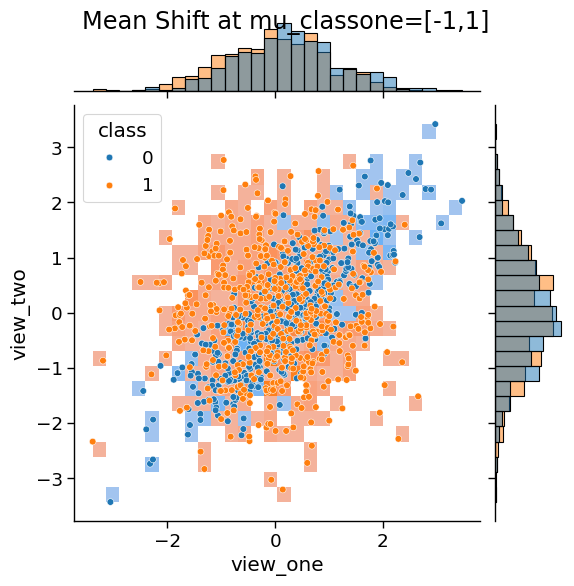

In [110]:
sns.set_context("paper", font_scale=1.5)
# fig, ax = plt.subplots()
g = sns.jointplot(
    x="view_one",
    y="view_two",
    hue="class",
    data=df,
    kind="hist",
)
sns.scatterplot(data=df, x="view_one", y="view_two", hue="class", ax=g.ax_joint)
g = g.fig.suptitle("Mean Shift at mu_classone=[-1,1]")

## Compare Multiview RF vs OF

In [6]:
def _estimate_threshold(y_true, y_score, target_specificity=0.98, pos_label=1):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)

    # Find the threshold corresponding to the target specificity
    index = np.argmax(fpr >= (1 - target_specificity))
    threshold_at_specificity = thresholds[index]

    return threshold_at_specificity


def sensitivity_at_specificity(
    y_true, y_score, target_specificity=0.98, pos_label=1, threshold=None
):
    n_trees, n_samples, n_classes = y_score.shape

    # Compute nan-averaged y_score along the trees axis
    y_score_avg = np.nanmean(y_score, axis=0)

    # Extract true labels and nan-averaged predicted scores for the positive class
    y_true = y_true.ravel()
    y_score_binary = y_score_avg[:, 1]

    # Identify rows with NaN values in y_score_binary
    nan_rows = np.isnan(y_score_binary)

    # Remove NaN rows from y_score_binary and y_true
    y_score_binary = y_score_binary[~nan_rows]
    y_true = y_true[~nan_rows]

    if threshold is None:
        # Find the threshold corresponding to the target specificity
        threshold_at_specificity = _estimate_threshold(
            y_true, y_score_binary, target_specificity=0.98, pos_label=1
        )
    else:
        threshold_at_specificity = threshold

    # Use the threshold to classify predictions
    y_pred_at_specificity = (y_score_binary >= threshold_at_specificity).astype(int)

    # Compute sensitivity at the chosen specificity
    sensitivity = np.sum((y_pred_at_specificity == 1) & (y_true == 1)) / np.sum(
        y_true == 1
    )

    return sensitivity

In [7]:
rng = np.random.default_rng(1234)
n_samples = 4096
n_dim_1 = 4090
default_n_informative = 2
mu_0 = [0, 0.2]
mu_1 = [0, 0]
seed = None
n_dim_2 = 6

cov2 = np.eye(2)

# simulate data with covariance in two views
X, y, means, cov = make_trunk_classification(
    n_samples=n_samples,
    n_dim=n_dim_1 + 1,
    n_informative=default_n_informative,
    mu_0=mu_0,
    mu_1=mu_1,
    cov2=cov2,
    return_params=True,
    rho=0.8,
    seed=seed,
)

# get the second informative dimension
view_1 = X[:, 1:]

# only take one informative dimension
view_2 = X[:, (0,)]

# add noise to the second view so that view_2 = (n_samples, n_dim_2)
view_2 = np.concatenate(
    (view_2, rng.standard_normal(size=(n_samples, n_dim_2 - view_2.shape[1]))),
    axis=1,
)
X = np.concatenate((view_1, view_2), axis=1)

n_dims_2_ = 6
n_dims_1_ = 4090
target_specificity = 0.98
feature_set_ends = [
    n_dims_1_,
    n_dims_1_ + n_dims_2_,
]  # [4090, 4096] for varying samples
max_features = 0.3
n_estimators = 1000

In [112]:
might_kwargs = {
    "n_estimators": n_estimators,
    "honest_fraction": 0.5,
    "n_jobs": -1,
    "bootstrap": True,
    "stratify": True,
    "max_samples": 1.6,
    "max_features": max_features,
    "feature_combinations": 3,
    "cross_feature_sampling": True,
    "tree_estimator": MultiViewObliqueDecisionTreeClassifier(),
}
est = HonestForestClassifier(
    seed=seed, feature_set_ends=feature_set_ends, **might_kwargs
)

est, posterior_arr = build_oob_forest(
    est,
    X,
    y,
    verbose=False,
)
print(feature_set_ends, X.shape, n_samples, n_dims_1_, n_dims_2_)
print(max([tree.get_depth() for tree in est.estimators_]))

# Compute nan-averaged y_score along the trees axis
y_score_avg = np.nanmean(posterior_arr, axis=0)

# Extract true labels and nan-averaged predicted scores for the positive class
y_true = y.ravel()
y_score_binary = y_score_avg[:, 1]

# Identify rows with NaN values in y_score_binary
nan_rows = np.isnan(y_score_binary)

# Remove NaN rows from y_score_binary and y_true
y_score_binary = y_score_binary[~nan_rows]
y_true = y_true[~nan_rows]

threshold_at_specificity = _estimate_threshold(
    y_true, y_score_binary, target_specificity=0.98, pos_label=1
)

# generate S@S98 from posterior array
sas98 = sensitivity_at_specificity(
    y,
    posterior_arr,
    target_specificity=target_specificity,
    threshold=threshold_at_specificity,
)

print(sas98)

[4090, 4096] (4096, 4096) 4096 4090 6
46
0.06494140625


In [113]:
might_kwargs = {
    "n_estimators": n_estimators,
    "honest_fraction": 0.5,
    "n_jobs": 1,
    "bootstrap": True,
    "stratify": True,
    "max_samples": 1.6,
    "max_features": max_features,
    # "feature_combinations": 2,
    # "cross_feature_sampling": True,
    "tree_estimator": MultiViewDecisionTreeClassifier(),
}
est = HonestForestClassifier(
    seed=seed, feature_set_ends=feature_set_ends, **might_kwargs
)

est, posterior_arr = build_oob_forest(
    est,
    X,
    y,
    verbose=False,
)
print(feature_set_ends, X.shape, n_samples, n_dims_1_, n_dims_2_)
print(max([tree.get_depth() for tree in est.estimators_]))

# Compute nan-averaged y_score along the trees axis
y_score_avg = np.nanmean(posterior_arr, axis=0)

# Extract true labels and nan-averaged predicted scores for the positive class
y_true = y.ravel()
y_score_binary = y_score_avg[:, 1]

# Identify rows with NaN values in y_score_binary
nan_rows = np.isnan(y_score_binary)

# Remove NaN rows from y_score_binary and y_true
y_score_binary = y_score_binary[~nan_rows]
y_true = y_true[~nan_rows]

threshold_at_specificity = _estimate_threshold(
    y_true, y_score_binary, target_specificity=0.98, pos_label=1
)

# generate S@S98 from posterior array
sas98 = sensitivity_at_specificity(
    y,
    posterior_arr,
    target_specificity=target_specificity,
    threshold=threshold_at_specificity,
)

print(sas98)

[4090, 4096] (4096, 4096) 4096 4090 6
45
0.080078125


In [114]:
print(feature_set_ends)

[4090, 4096]


In [115]:
might_kwargs = {
    "n_estimators": n_estimators,
    "honest_fraction": 0.5,
    "n_jobs": -1,
    "bootstrap": True,
    "stratify": True,
    "max_samples": 1.6,
    "max_features": max_features,
    "feature_combinations": 3,
    "cross_feature_sampling": False,
    "tree_estimator": MultiViewObliqueDecisionTreeClassifier(),
}
est = HonestForestClassifier(
    seed=seed, feature_set_ends=feature_set_ends, **might_kwargs
)

est, posterior_arr = build_oob_forest(
    est,
    X,
    y,
    verbose=False,
)
print(feature_set_ends, X.shape, n_samples, n_dims_1_, n_dims_2_)
print(max([tree.get_depth() for tree in est.estimators_]))

# Compute nan-averaged y_score along the trees axis
y_score_avg = np.nanmean(posterior_arr, axis=0)

# Extract true labels and nan-averaged predicted scores for the positive class
y_true = y.ravel()
y_score_binary = y_score_avg[:, 1]

# Identify rows with NaN values in y_score_binary
nan_rows = np.isnan(y_score_binary)

# Remove NaN rows from y_score_binary and y_true
y_score_binary = y_score_binary[~nan_rows]
y_true = y_true[~nan_rows]

threshold_at_specificity = _estimate_threshold(
    y_true, y_score_binary, target_specificity=0.98, pos_label=1
)

# generate S@S98 from posterior array
sas98 = sensitivity_at_specificity(
    y,
    posterior_arr,
    target_specificity=target_specificity,
    threshold=threshold_at_specificity,
)

print(sas98)

[4090, 4096] (4096, 4096) 4096 4090 6
45
0.05712890625


In [8]:
might_kwargs = {
    "n_estimators": n_estimators,
    "honest_fraction": 0.5,
    "n_jobs": 2,
    "bootstrap": True,
    "stratify": True,
    "max_samples": 1.6,
    "max_features": max_features,
    "feature_combinations": 2.0,
    # "cross_feature_sampling": True,
    "tree_estimator": ObliqueDecisionTreeClassifier(),
}
est = HonestForestClassifier(
    seed=seed, feature_set_ends=feature_set_ends, **might_kwargs
)

est, posterior_arr = build_oob_forest(
    est,
    X,
    y,
    verbose=False,
)
print(feature_set_ends, X.shape, n_samples, n_dims_1_, n_dims_2_)
print(max([tree.get_depth() for tree in est.estimators_]))

# Compute nan-averaged y_score along the trees axis
y_score_avg = np.nanmean(posterior_arr, axis=0)

# Extract true labels and nan-averaged predicted scores for the positive class
y_true = y.ravel()
y_score_binary = y_score_avg[:, 1]

# Identify rows with NaN values in y_score_binary
nan_rows = np.isnan(y_score_binary)

# Remove NaN rows from y_score_binary and y_true
y_score_binary = y_score_binary[~nan_rows]
y_true = y_true[~nan_rows]

threshold_at_specificity = _estimate_threshold(
    y_true, y_score_binary, target_specificity=0.98, pos_label=1
)

# generate S@S98 from posterior array
sas98 = sensitivity_at_specificity(
    y,
    posterior_arr,
    target_specificity=target_specificity,
    threshold=threshold_at_specificity,
)

print(sas98)

[4090, 4096] (4096, 4096) 4096 4090 6
53
0.0234375


In [11]:
might_kwargs = {
    "n_estimators": n_estimators,
    "honest_fraction": 0.5,
    "n_jobs": -1,
    "bootstrap": True,
    "stratify": True,
    "max_samples": 1.6,
    "max_features": max_features,
    "feature_combinations": 10,
    "cross_feature_sampling": True,
    "tree_estimator": MultiViewObliqueDecisionTreeClassifier(),
}
est = HonestForestClassifier(
    seed=seed, feature_set_ends=feature_set_ends, **might_kwargs
)

est, posterior_arr = build_oob_forest(
    est,
    X,
    y,
    verbose=False,
)
print(feature_set_ends, X.shape, n_samples, n_dims_1_, n_dims_2_)
print(max([tree.get_depth() for tree in est.estimators_]))

# Compute nan-averaged y_score along the trees axis
y_score_avg = np.nanmean(posterior_arr, axis=0)

# Extract true labels and nan-averaged predicted scores for the positive class
y_true = y.ravel()
y_score_binary = y_score_avg[:, 1]

# Identify rows with NaN values in y_score_binary
nan_rows = np.isnan(y_score_binary)

# Remove NaN rows from y_score_binary and y_true
y_score_binary = y_score_binary[~nan_rows]
y_true = y_true[~nan_rows]

threshold_at_specificity = _estimate_threshold(
    y_true, y_score_binary, target_specificity=0.98, pos_label=1
)

# generate S@S98 from posterior array
sas98 = sensitivity_at_specificity(
    y,
    posterior_arr,
    target_specificity=target_specificity,
    threshold=threshold_at_specificity,
)

print(sas98)

[4090, 4096] (4096, 4096) 4096 4090 6
41
0.0634765625


In [10]:
print("done")

done
